In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

if torch.cuda.is_available():
    print('CUDA is available. Working on GPU')
    DEVICE = torch.device('cuda')
else:
    print('CUDA is not available. Working on CPU')
    DEVICE = torch.device('cpu')

CUDA is available. Working on GPU


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Data Loading & preprocessing**

In [ ]:
# load train and test csv's with all image paths and targets
train_img_paths = pd.read_csv('drive/MyDrive/MURA-v1.1/train_image_paths.csv', header = None, names = ['image_path'])
test_img_paths = pd.read_csv('drive/MyDrive/MURA-v1.1/valid_image_paths.csv', header = None, names = ['image_path'])

In [ ]:
# funtion to extract info from train and test dataframes
def split_img_paths(df):
    temp = df['image_path'].str.split('/', expand=True)
    new_df = pd.DataFrame(df['image_path'])
    new_df['patient_id'] = temp[3]
    new_df['study'] = temp[4].str.split('_', expand = True)[0].str[-1:].astype(int)
    new_df['region'] = temp[2].str.split('_', expand = True)[1]
    map = {'positive':'abnormal', 'negative':'normal'}
    new_df['target'] = temp[4].str.split('_', expand = True)[1]
    new_df['target'] = new_df['target'].map(map)
    #add google drive location to image path
    new_df['image_path'] = 'drive/MyDrive/' + new_df['image_path']
    
    return new_df

In [ ]:
# create df with info extracted
mura_train = split_img_paths(train_img_paths)
mura_test = split_img_paths(test_img_paths)
mura_train.head()

,image_path,patient_id,study,region,target
0,drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/pati...,patient00001,1,SHOULDER,abnormal
1,drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/pati...,patient00001,1,SHOULDER,abnormal
2,drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/pati...,patient00001,1,SHOULDER,abnormal
3,drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/pati...,patient00002,1,SHOULDER,abnormal
4,drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/pati...,patient00002,1,SHOULDER,abnormal


In [ ]:
data_transforms = transforms.Compose([
    #
    #note that output channel is 1, will need to change and re-run for use with 3 channels
    #
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [ ]:
def class_dict(two_targets):
    classes_2 = ['normal', 'abnormal']
    dict_2 = {'normal' : 0, 'abnormal': 1}
    
    return classes_2, dict_2

In [ ]:
class MuraDataset(Dataset):
    # change two targets to False if using 14 target data
    def __init__(self, mura_df, two_targets, transform=data_transforms):
        self.mura = mura_df
        self.transform = transform
        self.classes, self.class_to_idx = class_dict(two_targets=two_targets)

    def __len__(self):
        return len(self.mura)

    # retrives image from path in df file and target from df
    def get_image_class(self, index):
        image_path = self.mura.iloc[index]['image_path']
        class_name = self.mura.iloc[index]['target']
        return Image.open(image_path), class_name  

    def __getitem__(self, idx):
        image, class_name = self.get_image_class(idx)
        label = self.class_to_idx[class_name]

        return self.transform(image), label
        

In [ ]:
mura_train_dataset = MuraDataset(mura_df = mura_train, two_targets=True)
mura_train_dataset = MuraDataset(mura_df = mura_train, two_targets=True)

In [ ]:
# create train df by region
wrist_train = mura_train[mura_train['region']=='WRIST']
forearm_train = mura_train[mura_train['region']=='FOREARM']
hand_train = mura_train[mura_train['region']=='HAND']
humerus_train = mura_train[mura_train['region']=='HUMERUS']
elbow_train = mura_train[mura_train['region']=='ELBOW']
shoulder_train = mura_train[mura_train['region']=='SHOULDER']
finger_train = mura_train[mura_train['region']=='FINGER']

# create test df by region
wrist_test = mura_test[mura_test['region']=='WRIST']
forearm_test = mura_test[mura_test['region']=='FOREARM']
hand_test = mura_test[mura_test['region']=='HAND']
humerus_test = mura_test[mura_test['region']=='HUMERUS']
elbow_test = mura_test[mura_test['region']=='ELBOW']
shoulder_test = mura_test[mura_test['region']=='SHOULDER']
finger_test = mura_test[mura_test['region']=='FINGER']

In [ ]:
# create train datasets by region
wrist_train_dataset = MuraDataset(mura_df = wrist_train, two_targets=True)
forearm_train_dataset = MuraDataset(mura_df = forearm_train, two_targets=True)
hand_train_dataset = MuraDataset(mura_df = hand_train, two_targets=True)
humerus_train_dataset = MuraDataset(mura_df = humerus_train, two_targets=True)
elbow_train_dataset = MuraDataset(mura_df = elbow_train, two_targets=True)
shoulder_train_dataset = MuraDataset(mura_df = shoulder_train, two_targets=True)
finger_train_dataset = MuraDataset(mura_df = finger_train, two_targets=True)

# create test datasets by region
wrist_test_dataset = MuraDataset(mura_df = wrist_test, two_targets=True)
forearm_test_dataset = MuraDataset(mura_df = forearm_test, two_targets=True)
hand_test_dataset = MuraDataset(mura_df = hand_test, two_targets=True)
humerus_test_dataset = MuraDataset(mura_df = humerus_test, two_targets=True)
elbow_test_dataset = MuraDataset(mura_df = elbow_test, two_targets=True)
shoulder_test_dataset = MuraDataset(mura_df = shoulder_test, two_targets=True)
finger_test_dataset = MuraDataset(mura_df = finger_test, two_targets=True)

## **Sample Dataset**

In [ ]:
wrist_len = len(wrist_train)
forearm_len = len(forearm_train)
hand_len = len(hand_train)
humerus_len = len(humerus_train)
elbow_len = len(elbow_train)
shoulder_len = len(shoulder_train)
finger_len = len(finger_train)

total = len(mura_train)

# ratio of portion of samples we want from each region
wrist_ratio = round(wrist_len/total,5)
forearm_ratio = round(forearm_len/total,5)
hand_ratio = round(hand_len/total,5)
humerus_ratio = round(humerus_len/total,5)
elbow_ratio = round(elbow_len/total,5)
shoulder_ratio = round(shoulder_len/total,5)
finger_ratio = round(finger_len/total,5)

In [ ]:
def mura_sample(num_samples):
    a = wrist_train.sample(n=int(wrist_ratio*num_samples))
    b = forearm_train.sample(n=int(forearm_ratio*num_samples)) 
    c = hand_train.sample(n=int(hand_ratio*num_samples)) 
    d = humerus_train.sample(n=int(humerus_ratio*num_samples)) 
    el = elbow_train.sample(n=int(elbow_ratio*num_samples)) 
    f = shoulder_train.sample(n=int(shoulder_ratio*num_samples)) 
    g = finger_train.sample(n=int(finger_ratio*num_samples)) 
    
    frames = [a,b,c,d,el,f,g]
    keys = mura_test.columns
    result = pd.concat(frames, keys=keys)

    ds = MuraDataset(mura_df = result, two_targets=False)
    return ds

In [ ]:
mura_train_subset = mura_sample(7000) 

In [ ]:
len(mura_train_subset)

4433

In [ ]:
wrist_l = len(wrist_test)
forearm_l = len(forearm_test)
hand_l = len(hand_test)
humerus_l = len(humerus_test)
elbow_l = len(elbow_test)
shoulder_l = len(shoulder_test)
finger_l = len(finger_test)

total = len(mura_test)

# ratio of portion of samples we want from each region
wrist_rat = round(wrist_l/total,5)
forearm_rat = round(forearm_l/total,5)
hand_rat = round(hand_l/total,5)
humerus_rat = round(humerus_l/total,5)
elbow_rat = round(elbow_l/total,5)
shoulder_rat = round(shoulder_l/total,5)
finger_rat = round(finger_l/total,5)

In [ ]:
def mura_test_sample(num_samples):
    a = wrist_test.sample(n=int(wrist_rat*num_samples))
    b = forearm_test.sample(n=int(forearm_rat*num_samples)) 
    c = hand_test.sample(n=int(hand_rat*num_samples)) 
    d = humerus_test.sample(n=int(humerus_rat*num_samples)) 
    el = elbow_test.sample(n=int(elbow_rat*num_samples)) 
    f = shoulder_test.sample(n=int(shoulder_rat*num_samples)) 
    g = finger_test.sample(n=int(finger_rat*num_samples)) 
    
    frames = [a,b,c,d,el,f,g]
    keys = mura_test.columns
    result = pd.concat(frames, keys=keys)

    ds = MuraDataset(mura_df = result, two_targets=False)
    return ds

In [ ]:
mura_test_subset = mura_sample(2000) 

In [ ]:
len(mura_test_subset)

1265

## **Model Building**

In [ ]:
def training(model, model_name, num_epochs, train_dataloader, test_dataloader):

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)

    train_loss_array = []
    train_acc_array = []
    test_loss_array = []
    test_acc_array = []
    lowest_test_loss = np.inf
    best_model = None

    for epoch in tqdm(range(num_epochs)):

        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, scheduler.get_lr()))

        for phase in ['train', 'val']:

            epoch_loss = 0
            epoch_correct_items = 0
            epoch_items = 0

            if phase == 'train':
                model.train()
                with torch.enable_grad():
                    for samples, targets in train_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        optimizer.zero_grad()
                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()
                        
                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                train_loss_array.append(epoch_loss / epoch_items)
                train_acc_array.append(epoch_correct_items / epoch_items)

                scheduler.step()

            elif phase == 'val':
                model.eval()
                with torch.no_grad():
                    for samples, targets in test_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                test_loss_array.append(epoch_loss / epoch_items)
                test_acc_array.append(epoch_correct_items / epoch_items)

                if epoch_loss / epoch_items < lowest_test_loss:
                    lowest_test_loss = epoch_loss / epoch_items
                    torch.save(model.state_dict(), '{}_weights.pth'.format(model_name))
                    best_model = copy.deepcopy(model)
                    print("\t| New lowest test loss for {}: {}".format(model_name, lowest_test_loss))

    return best_model, train_loss_array, train_acc_array, test_loss_array, test_acc_array
    


In [ ]:
train_dataloader = DataLoader(mura_train_subset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(mura_test_subset, batch_size=64, shuffle=False)
num_epochs = 15

## **DenseNet Model**

In [ ]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=200)
model_densenet161 = model_densenet161.to(DEVICE)

densenet161_training_results = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=train_dataloader,
                                        test_dataloader=test_dataloader)

model_densenet161, train_loss_array, train_acc_array, test_loss_array, test_acc_array = densenet161_training_results

min_loss = min(test_loss_array)
min_loss_epoch = test_loss_array.index(min_loss)
min_loss_accuracy = test_acc_array[min_loss_epoch]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 1 | Learning rate: [0.0003]


  7%|▋         | 1/15 [1:18:43<18:22:05, 4723.22s/it]

	| New lowest test loss for DenseNet161: 0.010396043490986578
Epoch: 2 | Learning rate: [0.0003]


 13%|█▎        | 2/15 [1:20:10<7:12:30, 1996.18s/it] 

	| New lowest test loss for DenseNet161: 0.009558412444450168
Epoch: 3 | Learning rate: [0.0003]


 20%|██        | 3/15 [1:21:37<3:44:51, 1124.28s/it]

	| New lowest test loss for DenseNet161: 0.009045493838344167
Epoch: 4 | Learning rate: [3.267e-05]


 27%|██▋       | 4/15 [1:23:03<2:11:01, 714.67s/it] 

	| New lowest test loss for DenseNet161: 0.008921816933296415
Epoch: 5 | Learning rate: [9.9e-05]


 33%|███▎      | 5/15 [1:24:30<1:21:22, 488.28s/it]

	| New lowest test loss for DenseNet161: 0.00881937582031069
Epoch: 6 | Learning rate: [9.9e-05]


 40%|████      | 6/15 [1:25:57<52:45, 351.76s/it]  

	| New lowest test loss for DenseNet161: 0.008715694459530675
Epoch: 7 | Learning rate: [1.0781099999999999e-05]


 47%|████▋     | 7/15 [1:27:23<35:19, 264.95s/it]

	| New lowest test loss for DenseNet161: 0.008701218093336807
Epoch: 8 | Learning rate: [3.267e-05]


 53%|█████▎    | 8/15 [1:28:50<24:17, 208.15s/it]

	| New lowest test loss for DenseNet161: 0.008664159718238317
Epoch: 9 | Learning rate: [3.267e-05]


 60%|██████    | 9/15 [1:30:16<17:01, 170.17s/it]

	| New lowest test loss for DenseNet161: 0.008625144049112975
Epoch: 10 | Learning rate: [3.557763e-06]


 67%|██████▋   | 10/15 [1:31:43<12:01, 144.32s/it]

	| New lowest test loss for DenseNet161: 0.008618250760165128
Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 73%|███████▎  | 11/15 [1:33:10<08:27, 126.76s/it]

	| New lowest test loss for DenseNet161: 0.008597433355014786
Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 80%|████████  | 12/15 [1:34:36<05:43, 114.56s/it]

Epoch: 13 | Learning rate: [1.17406179e-06]


 87%|████████▋ | 13/15 [1:36:04<03:32, 106.24s/it]

	| New lowest test loss for DenseNet161: 0.008593763028208917
Epoch: 14 | Learning rate: [3.557763e-06]


 93%|█████████▎| 14/15 [1:37:30<01:40, 100.34s/it]

	| New lowest test loss for DenseNet161: 0.008589638457467904
Epoch: 15 | Learning rate: [3.557763e-06]


100%|██████████| 15/15 [1:38:57<00:00, 395.83s/it]

	| New lowest test loss for DenseNet161: 0.008588070525482237


In [ ]:
print("\nTraining results:")
print("\tMin test loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\t test accuracy during min test loss is {:.4f}".format(min_loss_accuracy))


Training results:
	Min test loss 0.0086 was achieved during epoch #15
	 test accuracy during min test loss is 0.7478


## **ResNet Model**

In [ ]:
model_resnet152 = models.resnet152(pretrained=True)
for param in model_resnet152.parameters():
    param.requires_grad = False
model_resnet152.fc = torch.nn.Linear(model_resnet152.fc.in_features, 200)
model_resnet152 = model_resnet152.to(DEVICE)

resnet152_training_results = training(model=model_resnet152,
                                      model_name='ResNet152',
                                      num_epochs=num_epochs,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader)

model_resnet152, train_loss_array, train_acc_array, test_loss_array, test_acc_array = resnet152_training_results

min_loss = min(test_loss_array)
min_loss_epoch = test_loss_array.index(min_loss)
min_loss_accuracy = test_acc_array[min_loss_epoch]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


  7%|▋         | 1/15 [01:25<20:00, 85.76s/it]

	| New lowest test loss for ResNet152: 0.010153063907924849
Epoch: 2 | Learning rate: [0.0003]


 13%|█▎        | 2/15 [02:50<18:25, 85.01s/it]

	| New lowest test loss for ResNet152: 0.009332442095157186
Epoch: 3 | Learning rate: [0.0003]


 20%|██        | 3/15 [04:14<16:56, 84.73s/it]

	| New lowest test loss for ResNet152: 0.0089997290386984
Epoch: 4 | Learning rate: [3.267e-05]


 27%|██▋       | 4/15 [05:38<15:29, 84.47s/it]

	| New lowest test loss for ResNet152: 0.00895997961990447
Epoch: 5 | Learning rate: [9.9e-05]


 33%|███▎      | 5/15 [07:02<14:00, 84.10s/it]

Epoch: 6 | Learning rate: [9.9e-05]


 40%|████      | 6/15 [08:26<12:37, 84.15s/it]

	| New lowest test loss for ResNet152: 0.008854874391329618
Epoch: 7 | Learning rate: [1.0781099999999999e-05]


 47%|████▋     | 7/15 [09:51<11:15, 84.41s/it]

	| New lowest test loss for ResNet152: 0.008830320976468414
Epoch: 8 | Learning rate: [3.267e-05]


 53%|█████▎    | 8/15 [11:15<09:49, 84.26s/it]

	| New lowest test loss for ResNet152: 0.008794563160583435
Epoch: 9 | Learning rate: [3.267e-05]


 60%|██████    | 9/15 [12:39<08:25, 84.31s/it]

	| New lowest test loss for ResNet152: 0.008768173192329557
Epoch: 10 | Learning rate: [3.557763e-06]


 67%|██████▋   | 10/15 [14:03<07:00, 84.01s/it]

Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 73%|███████▎  | 11/15 [15:26<05:35, 83.85s/it]

Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 80%|████████  | 12/15 [16:50<04:11, 83.91s/it]

	| New lowest test loss for ResNet152: 0.00876063638525047
Epoch: 13 | Learning rate: [1.17406179e-06]


 87%|████████▋ | 13/15 [18:14<02:47, 83.84s/it]

	| New lowest test loss for ResNet152: 0.008760142609064757
Epoch: 14 | Learning rate: [3.557763e-06]


 93%|█████████▎| 14/15 [19:39<01:24, 84.23s/it]

	| New lowest test loss for ResNet152: 0.00875241188663739
Epoch: 15 | Learning rate: [3.557763e-06]


100%|██████████| 15/15 [21:04<00:00, 84.27s/it]

	| New lowest test loss for ResNet152: 0.008749379730036136


In [ ]:
print("\nTraining results:")
print("\tMin test loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tTest accuracy during min val loss is {:.4f}".format(min_loss_accuracy))


Training results:
	Min test loss 0.0087 was achieved during epoch #15
	Test accuracy during min val loss is 0.7289


## **Ensemble model**

In [ ]:
class EnsembleModel(nn.Module):   
    def __init__(self, modelA, modelB):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(200*2, 200)
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x = torch.cat((x1, x2), dim=1)
        out = self.classifier(x)
        return out
    
ensemble_model = EnsembleModel(model_densenet161, model_resnet152)

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True    

ensemble_model = ensemble_model.to(DEVICE)

In [ ]:
ensemble_training_results = training(model=ensemble_model,
                                     model_name='Ensemble',
                                     num_epochs=15,
                                     train_dataloader=train_dataloader,
                                     test_dataloader=test_dataloader)

ensemble_model, train_loss_array, train_acc_array, test_loss_array, test_acc_array = ensemble_training_results

min_loss = min(test_loss_array)
min_loss_iteration = test_loss_array.index(min_loss)
min_loss_accuracy = test_acc_array[min_loss_iteration]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


  7%|▋         | 1/15 [02:07<29:42, 127.34s/it]

	| New lowest test loss for Ensemble: 0.011071529878458015
Epoch: 2 | Learning rate: [0.0003]


 13%|█▎        | 2/15 [04:15<27:38, 127.58s/it]

	| New lowest test loss for Ensemble: 0.010879814012248525
Epoch: 3 | Learning rate: [0.0003]


 20%|██        | 3/15 [06:22<25:31, 127.65s/it]

	| New lowest test loss for Ensemble: 0.010864586980917709
Epoch: 4 | Learning rate: [3.267e-05]


 27%|██▋       | 4/15 [08:30<23:22, 127.53s/it]

	| New lowest test loss for Ensemble: 0.010731597097494857
Epoch: 5 | Learning rate: [9.9e-05]


 33%|███▎      | 5/15 [10:37<21:14, 127.48s/it]

	| New lowest test loss for Ensemble: 0.010708712212181845
Epoch: 6 | Learning rate: [9.9e-05]


 40%|████      | 6/15 [12:45<19:07, 127.52s/it]

	| New lowest test loss for Ensemble: 0.01069496648584901
Epoch: 7 | Learning rate: [1.0781099999999999e-05]


 47%|████▋     | 7/15 [14:51<16:57, 127.21s/it]

Epoch: 8 | Learning rate: [3.267e-05]


 53%|█████▎    | 8/15 [16:58<14:48, 126.98s/it]

Epoch: 9 | Learning rate: [3.267e-05]


 60%|██████    | 9/15 [19:04<12:40, 126.76s/it]

Epoch: 10 | Learning rate: [3.557763e-06]


 67%|██████▋   | 10/15 [21:10<10:33, 126.68s/it]

	| New lowest test loss for Ensemble: 0.010663628813777517
Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 73%|███████▎  | 11/15 [23:18<08:27, 126.81s/it]

	| New lowest test loss for Ensemble: 0.010651967883581229
Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 80%|████████  | 12/15 [25:24<06:19, 126.62s/it]

Epoch: 13 | Learning rate: [1.17406179e-06]


 87%|████████▋ | 13/15 [27:31<04:13, 126.72s/it]

	| New lowest test loss for Ensemble: 0.010644147707068402
Epoch: 14 | Learning rate: [3.557763e-06]


 93%|█████████▎| 14/15 [29:38<02:06, 126.80s/it]

	| New lowest test loss for Ensemble: 0.010640235239338026
Epoch: 15 | Learning rate: [3.557763e-06]


100%|██████████| 15/15 [31:44<00:00, 126.96s/it]


In [ ]:
print("\nTraining results:")
print("\tMin test loss {:.4f} was achieved during iteration #{}".format(min_loss, min_loss_iteration + 1))
print("\tTest accuracy during min test loss is {:.4f}".format(min_loss_accuracy))


Training results:
	Min test loss 0.0106 was achieved during iteration #14
	Test accuracy during min test loss is 0.6079


In [ ]:
print("\nTraining results:")
print("\tMin test loss {:.4f} was achieved during iteration #{}".format(min_loss, min_loss_iteration + 1))
print("\tTest accuracy during min test loss is {:.4f}".format(min_loss_accuracy))


Training results:
	Min test loss 0.0106 was achieved during iteration #20
	Test accuracy during min test loss is 0.6190


# **Results comparision**

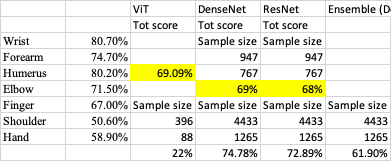